# CDK2 protein
## Data load and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [2]:
%run ./1_Helper_functions.ipynb

In [3]:
protein_name='cdk2'
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

R_a = round(y.sum() / len(y), 2)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(3466, 402)
415
Ra = 0.12


## Estimators
### ML Classifiers

In [4]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified", "random_state": 42}
dclf = DummyClassifier(**hyparams)

In [5]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [6]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [7]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [8]:
# ML Classifier
ml_classifiers = {
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
    'dclf': dclf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [9]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [10]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [11]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_02 = {'metric_name': 'ef', 
                    'fraction': 0.02, 'method':'normalized'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': 0.12, 'method':'normalized'},
             pROC = {'metric_name': 'p_roc'},
             pr_auc = {'metric_name': 'pr_auc'}
            )

# Hold-out Validation 

### 30 replicas


In [12]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def n_hold_out_validation_SAVE(filename, **kwargs):
    return n_hold_out_validation(**kwargs)

In [66]:
%%time
evaluation_name='ho30_MACTEST'
ho30 = n_hold_out_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_reps=30, random_state=42)

print(ho30.columns)
full_names = ['1-NN', 'Log. Reg.', 'XGB', 'DummyClf', 'csMEAN', 'csMAX', 'csMIN', 'csVOTE']
new_names = dict(zip(
    [*ho30.columns],
    full_names))

ho30 = ho30.rename(columns=new_names)

/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
File saved: ./cachedir/ho30_MACTEST_cdk2
Index(['ml_knn', 'ml_lr', 'ml_xgb', 'ml_dclf', 'cs_MEAN', 'cs_MAX', 'cs_MIN',
       'cs_VOTE'],
      dtype='object')
CPU times: user 17min 56s, sys: 17.6 s, total: 18min 13s
Wall time: 3min 56s


In [67]:
%run Friedman_and_Nemenyi_test.ipynb

In [68]:
%reload_ext rpy2.ipython

## AUC-ROC

In [69]:
%%R
packageVersion("httr")

[1] ‘1.4.2’


In [70]:
# ROC-AUC
metric_name='roc_auc'

# Normality
# display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))

display(friedmanTest(ho30.loc[metric_name]))

df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, 
                            test_size=0.25, random_state=42)

,statistic,p
Bartlett,45.603364,1.044126e-07


,chi^2,dof,p_value
Friedman Test,200.211111,7,1.035502e-39


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.2
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Registering fonts with R

R[write to console]: ------------------------------------------------------------------------------

R[write to console]: You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

R[write to console]: ------------------------------------------------------------------------------

R[write to console]: 
Attaching package: ‘plyr’


R[write to console]: The following objects are 

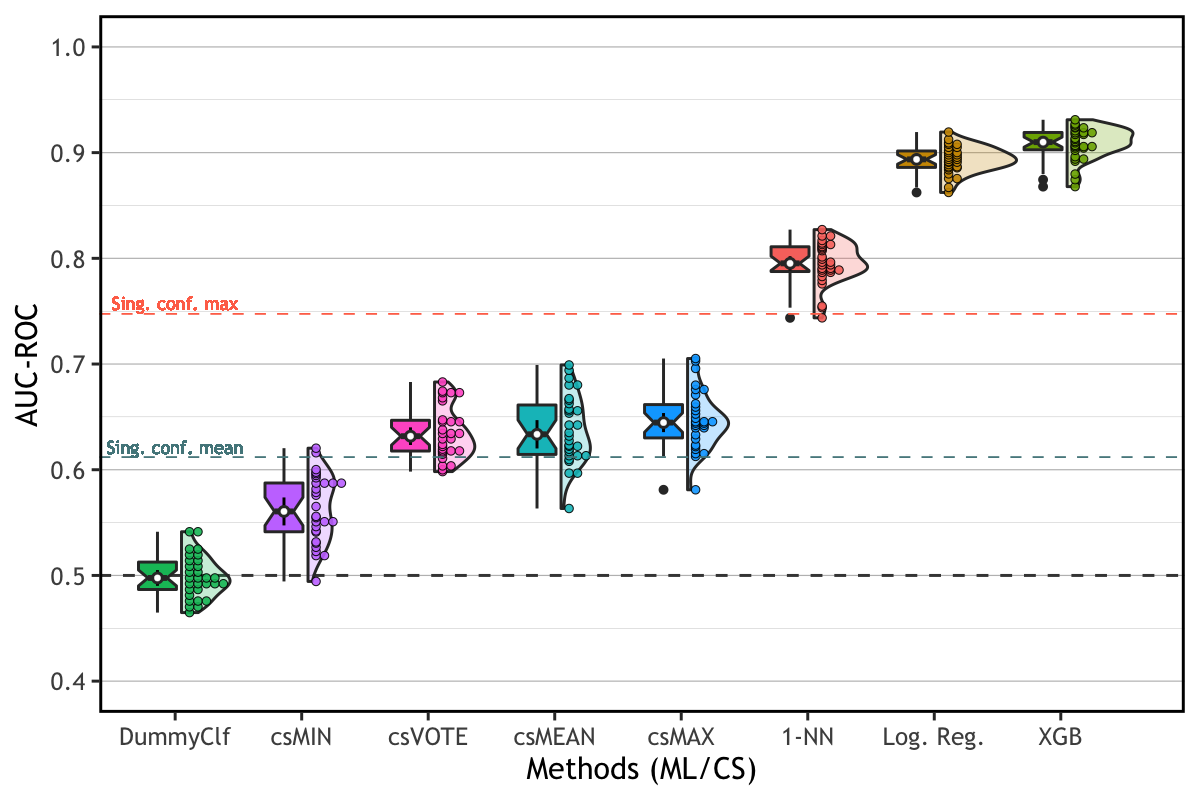

In [18]:
%%R -i full_names -i df_R -i single_mean -i single_max  -w 6 -h 4 --units in -r 200

library(tidyverse)
source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.4, y_max=1.) +
add_ref_values('Sing. conf. mean', single_mean, color='cadetblue4') + 
add_ref_values('Sing. conf. max', single_max, color='coral1')

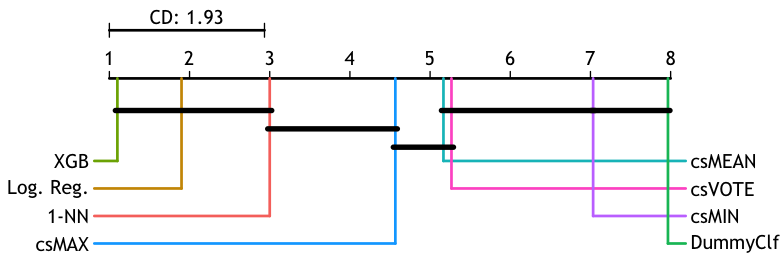

In [19]:
%%R -i df_R -i full_names -w 6 -h 2 --units in -r 130

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

R[write to console]: PMCMR is superseded by PMCMRplus and will be no longer maintained. You may wish to install PMCMRplus instead.

R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths




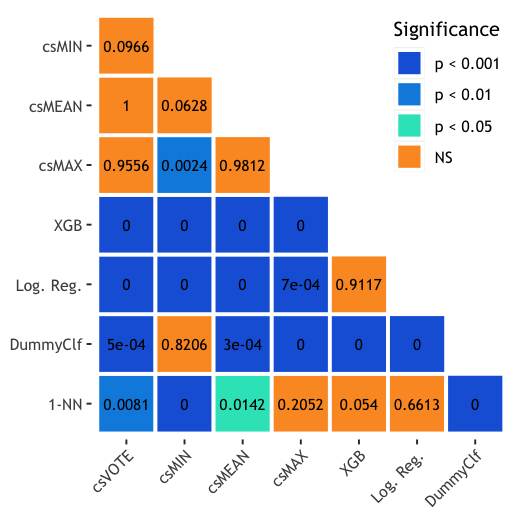

In [20]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

## pAUC-ROC Normalized

In [43]:
# Random value given n_a and N
test_size=0.25
N = y.size*0.25
n_a = y.sum()*0.25
print(N, n_a)
pROC_base_random = pROC_auc_rand(N, n_a, normalized=True)
print('Max pACU-ROC (non-normalized):', 1/N)
pROC_base_random

866.5 103.75
Max pACU-ROC (non-normalized): 0.001154068090017311


0.14766080669711348

In [44]:
# ROC-AUC
metric_name='pROC'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))
# Friedman test
display(friedmanTest(ho30.loc[metric_name]))

df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
# single_mean, single_max = n_hold_out_single_performance(X, y, 
#                             metrics[metric_name], n_reps=30, test_size=0.25, random_state=42)

,1-NN,Log. Reg.,XGB,DummyClf,csMEAN,csMAX,csMIN,csVOTE
Normality,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,23.510401,0.001388


,chi^2,dof,p_value
Friedman Test,206.288889,7,5.339816e-41


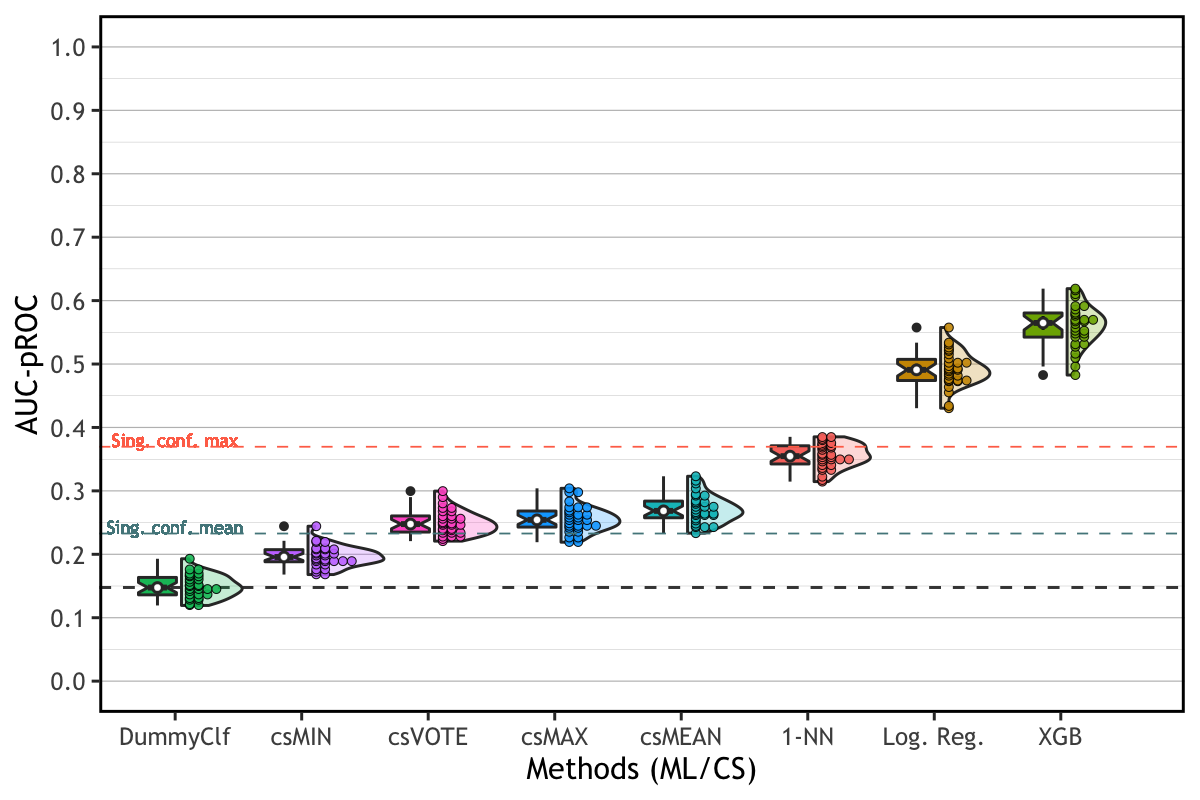

In [45]:
%%R -i full_names -i df_R -i single_mean -i single_max -ipROC_base_random -w 6 -h 4 --units in -r 200
source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.0, y_max=1., 
               dot_size=7, bin_width=0.002,
               y_label='AUC-pROC', base_h_line=pROC_base_random) +
add_ref_values('Sing. conf. mean', single_mean, color='cadetblue4') + 
add_ref_values('Sing. conf. max', single_max, color='coral1')

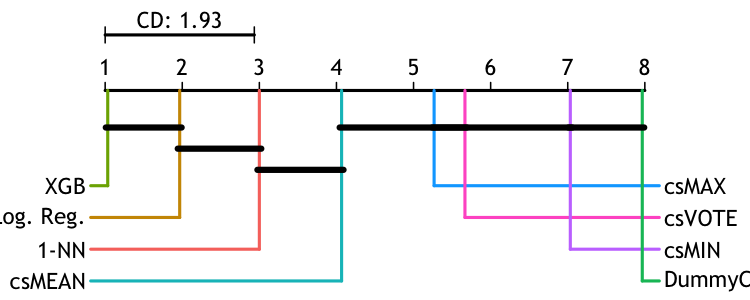

In [46]:
%%R -i df_R -i full_names -w 5 -h 2 --units in -r 150
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

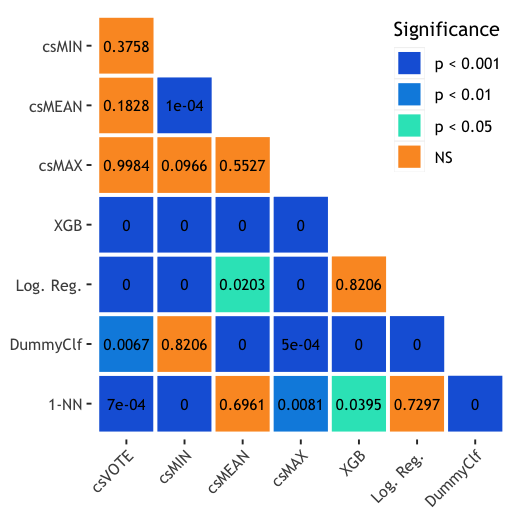

In [47]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

## EF 12% = Ra

In [52]:
# ROC-AUC
metric_name='nef_12_Ra'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))
# Friedman test
display(friedmanTest(ho30.loc[metric_name]))

df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.25, random_state=42)

,1-NN,Log. Reg.,XGB,DummyClf,csMEAN,csMAX,csMIN,csVOTE
Normality,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,4.015617,0.777977


,chi^2,dof,p_value
Friedman Test,203.766667,7,1.828075e-40


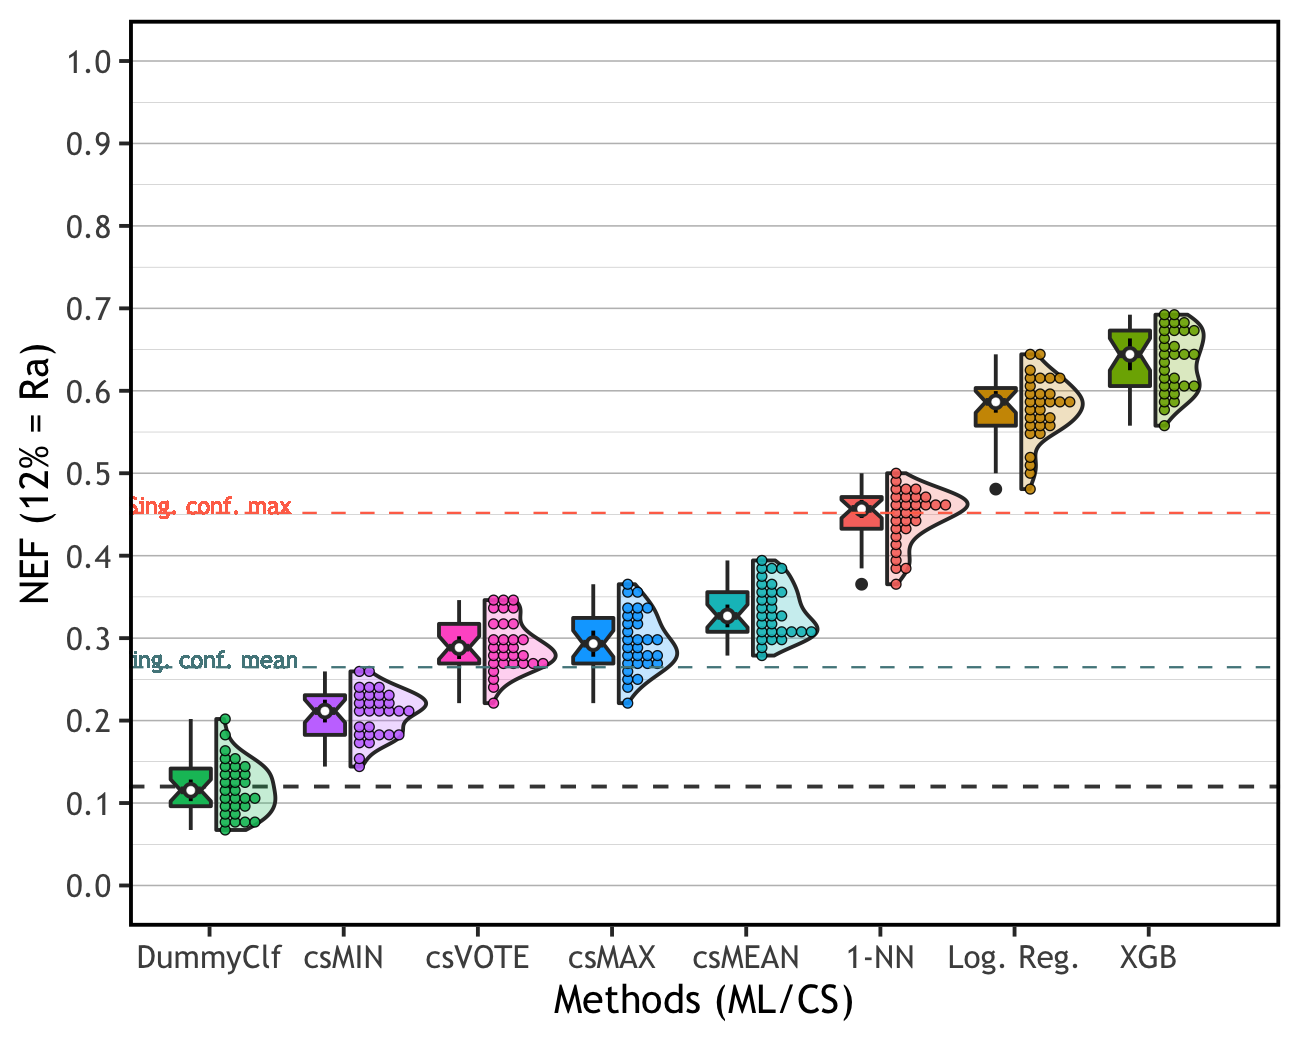

In [53]:
%%R -i df_Rmelted -i df_R -i full_names -i R_a -i single_mean -i single_max -w 5 -h 4 --units in -r 260 

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.0, y_max=1.0, 
               y_label='NEF (12% = Ra)', dot_size=12, bin_width=0.001, base_h_line=R_a) +
add_ref_values('Sing. conf. mean', single_mean, color='cadetblue4') + 
add_ref_values('Sing. conf. max', single_max, color='coral1')

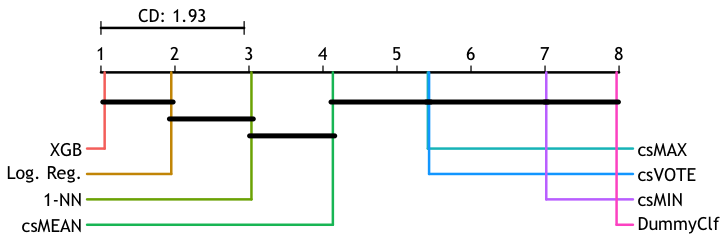

In [54]:
%%R -i df_R  -w 6 -h 2 --units in -r 120
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(rev(df_R))

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

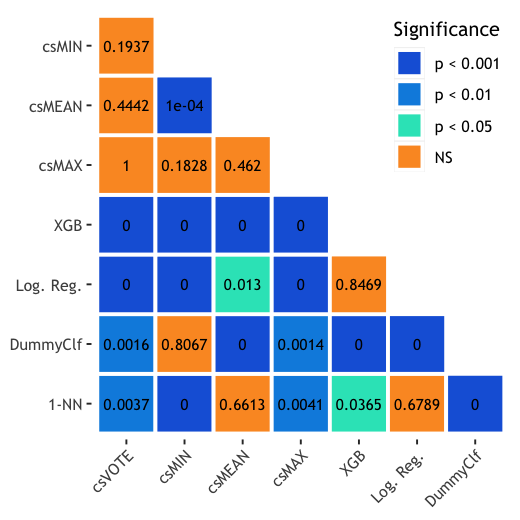

In [55]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

# Y-randomization test

In [56]:
@run_or_load_joblib
def n_hout_val_scrambling(filename, y, random_chi,  **kwargs):
    y_rand = randomize_y_labels(y_target=y, random_chi=random_chi)
    results = n_hold_out_validation(y=y_rand, **kwargs)
    return results

In [57]:
%%time
chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
n_reps=30
chi_results = {}
evaluation_name = f'y_scrambling_{n_reps}_reps'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = n_hout_val_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X, y=y, metrics=metrics, 
                             n_reps=n_reps, random_state=42)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result
    

File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-1
Fraction chi=1 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.75
Fraction chi=0.75 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.5
Fraction chi=0.5 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.25
Fraction chi=0.25 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.0
Fraction chi=0.0 finished.
CPU times: user 15.5 ms, sys: 4.83 ms, total: 20.3 ms
Wall time: 20.1 ms


## AUC-ROC

In [58]:
df_y_random = get_group_stats(chi_results, metric_name='roc_auc')
df_y_random = df_y_random.replace(new_names)

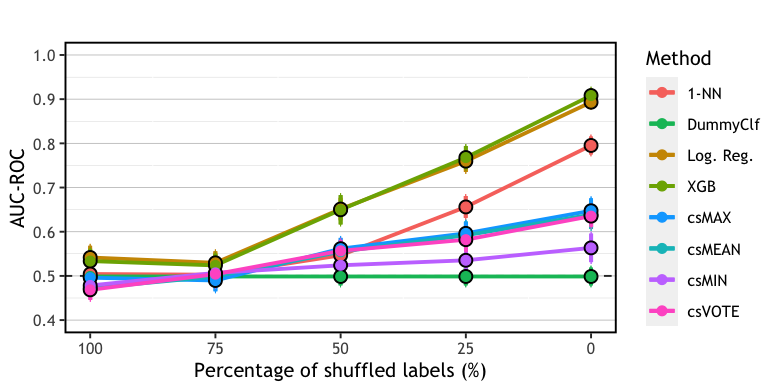

In [59]:
%%R -i df_y_random -i full_names -i df_R -w 6 -h 3 --units in -r 130
 

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(8)
names(cbbPalette) <- full_names

plot_lines(df_y_random, cbbPalette)

## AUC-pROC Normalized

In [60]:
df_y_random = get_group_stats(chi_results, metric_name='pROC')
df_y_random = df_y_random.replace(new_names)

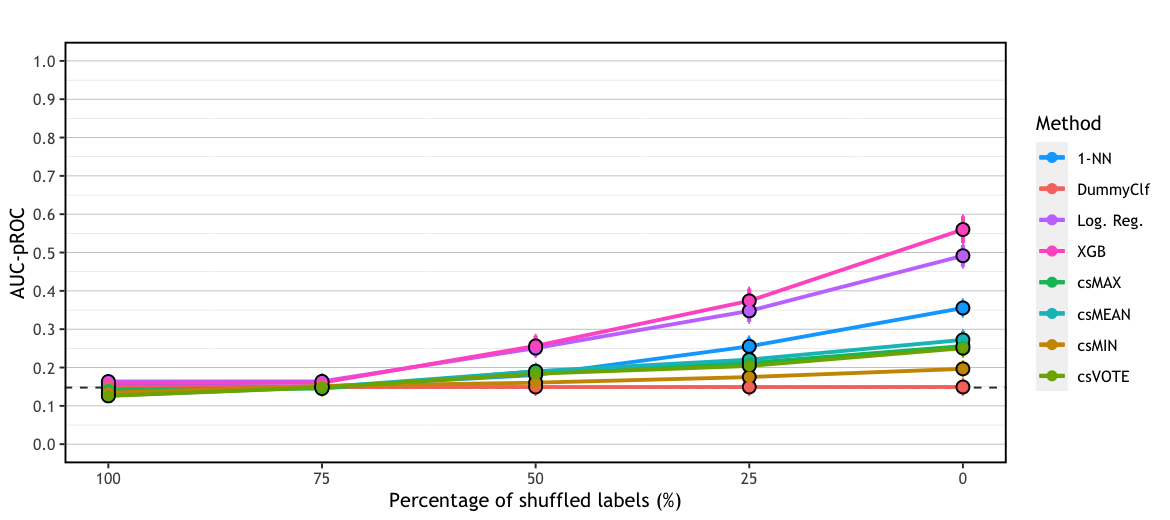

In [61]:
%%R -i df_y_random -i df_R -i pROC_base_random -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette, y_min=0.0, y_max=1., 
               y_label='AUC-pROC', base_h_line=pROC_base_random)

## EF 2% 

In [62]:
df_y_random = get_group_stats(chi_results, metric_name='nef_02')
df_y_random = df_y_random.replace(new_names)

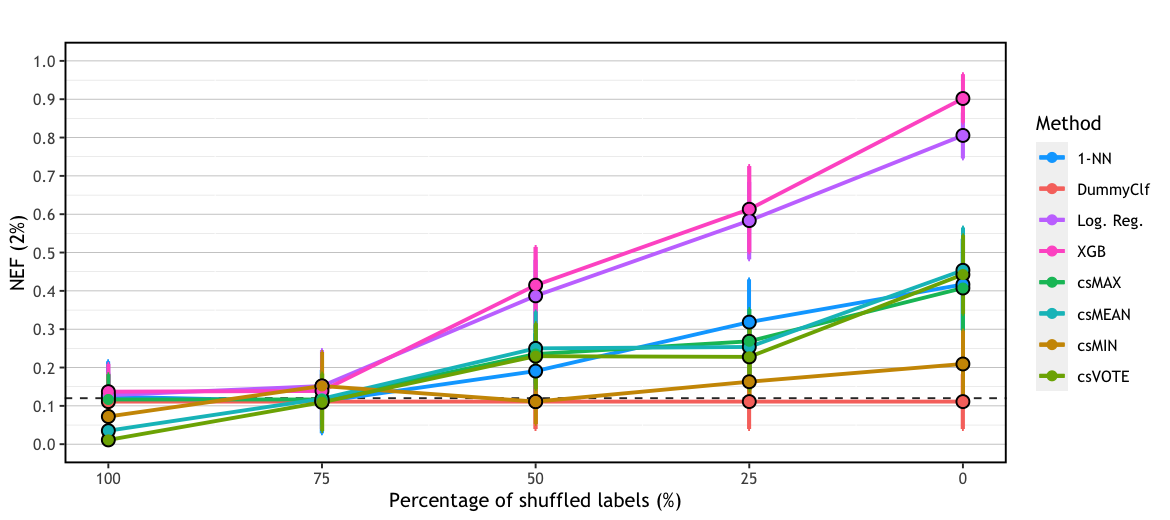

In [63]:
%%R -i df_y_random -i df_R -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette, y_min=0, base_h_line=0.12, y_label='NEF (2%)')

## EF 12% 

In [64]:
df_y_random = get_group_stats(chi_results, metric_name='nef_12_Ra')
df_y_random = df_y_random.replace(new_names)

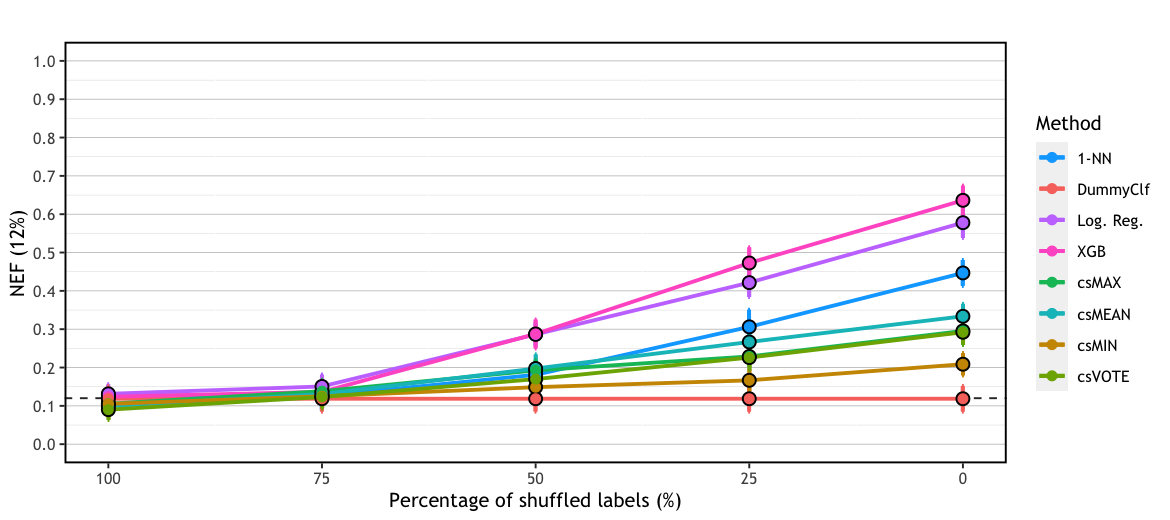

In [65]:
%%R -i df_y_random -i df_R -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette, y_min=0, y_max=1, base_h_line=0.12, y_label='NEF (12%)')